In [24]:
import json
from pathlib import Path
from typing import List

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random


In [25]:
# Пути
DATA_DIR = Path(r"E:\test_work\cubicasa5k-2.v1i.coco\valid")
GT_MASKS_DIR = Path(r"E:\test_work\masks\valid")

CV_PRED_DIR = Path(r"E:\test_work\outputs\opencv_infer")
UNET_PRED_DIR = Path(r"E:\test_work\outputs\unet_infer")

N_EXAMPLES = 3   # сколько примеров рисуем

# 0.0  -> фон полностью белый
# 0.5  -> фон приглушённый наполовину
# 1.0  -> фон как оригинальная картинка
BG_ALPHA_GT = 0.3
BG_ALPHA_CV = 0.3
BG_ALPHA_UNET = 0.3


In [26]:
def load_image_from_json(json_path: Path) -> np.ndarray:
    """
    Берём meta.source из json и грузим исходную картинку из DATA_DIR.
    """
    with json_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    src_name = data.get("meta", {}).get("source")
    if src_name is None:
        img_path = DATA_DIR / (json_path.stem + ".jpg")
    else:
        img_path = DATA_DIR / src_name

    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")

    return img


def load_gt_mask(stem: str) -> np.ndarray:
    """
    Грузим GT-маску по stem: <stem>_mask.png из GT_MASKS_DIR.
    """
    mask_path = GT_MASKS_DIR / f"{stem}_mask.png"
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Cannot read GT mask: {mask_path}")
    return mask


In [27]:
def make_faded_background(image_bgr: np.ndarray, alpha_bg: float) -> np.ndarray:
    """
    Делаем фон более светлым/прозрачным:
      alpha_bg = 1.0 -> оригинал
      alpha_bg = 0.0 -> полностью белый
    Линии позже рисуем поверх с полными цветами.
    """
    alpha_bg = float(np.clip(alpha_bg, 0.0, 1.0))
    h, w = image_bgr.shape[:2]
    white = np.ones((h, w, 3), dtype=np.uint8) * 255
    faded = cv2.addWeighted(image_bgr, alpha_bg, white, 1 - alpha_bg, 0.0)
    return faded


def draw_gt_on_background(
    image_bgr: np.ndarray,
    gt_mask: np.ndarray,
    alpha_bg: float,
) -> np.ndarray:
    """
    GT: фон = осветлённая оригинальная картинка, стен/двери/окна раскрашены.
    0 фон, 1 wall, 2 door, 3 window.
    """
    base = make_faded_background(image_bgr, alpha_bg)
    out = base.copy()

    color_map = {
        1: (0, 0, 255),  # wall   -> красный
        2: (0, 255, 0),  # door   -> зелёный
        3: (255, 0, 0),  # window -> синий
    }

    for cid, bgr in color_map.items():
        out[gt_mask == cid] = bgr

    return out



In [28]:
def draw_predictions_on_background(
    image_bgr: np.ndarray,
    json_data: dict,
    alpha_bg: float,
    use_walls: bool = True,
    use_doors: bool = True,
    use_windows: bool = True,
    use_ocr: bool = True,
    thickness: int = 2,
) -> np.ndarray:
    """
    Фон = осветлённая оригинальная картинка.
    Сверху рисуем линии классов + OCR.
    Цвета:
      walls   -> красный
      doors   -> зелёный
      windows -> синий
      OCR bbox + текст -> чёрный
    """
    base = make_faded_background(image_bgr, alpha_bg)
    out = base.copy()

    color_map = {
        "walls": (0, 0, 255),    # red
        "doors": (0, 255, 0),    # green
        "windows": (255, 0, 0),  # blue
    }

    # walls
    if use_walls:
        for item in json_data.get("walls", []):
            pts = item.get("points", [])
            if len(pts) < 2:
                continue
            pts_arr = np.array(pts, dtype=np.int32)
            color = color_map["walls"]
            if pts_arr.shape[0] == 2:
                p1 = tuple(pts_arr[0])
                p2 = tuple(pts_arr[1])
                cv2.line(out, p1, p2, color, thickness)
            else:
                cv2.polylines(out, [pts_arr], isClosed=False, color=color, thickness=thickness)

    # doors
    if use_doors:
        for item in json_data.get("doors", []):
            pts = item.get("points", [])
            if len(pts) < 2:
                continue
            pts_arr = np.array(pts, dtype=np.int32)
            color = color_map["doors"]
            if pts_arr.shape[0] == 2:
                p1 = tuple(pts_arr[0])
                p2 = tuple(pts_arr[1])
                cv2.line(out, p1, p2, color, thickness)
            else:
                cv2.polylines(out, [pts_arr], isClosed=False, color=color, thickness=thickness)

    # windows
    if use_windows:
        for item in json_data.get("windows", []):
            pts = item.get("points", [])
            if len(pts) < 2:
                continue
            pts_arr = np.array(pts, dtype=np.int32)
            color = color_map["windows"]
            if pts_arr.shape[0] == 2:
                p1 = tuple(pts_arr[0])
                p2 = tuple(pts_arr[1])
                cv2.line(out, p1, p2, color, thickness)
            else:
                cv2.polylines(out, [pts_arr], isClosed=False, color=color, thickness=thickness)

    # OCR
    if use_ocr:
        for item in json_data.get("ocr", []):
            bbox = item.get("bbox", None)
            raw_text = item.get("text", "")
            if not bbox or len(bbox) != 4:
                continue

            x, y, w_box, h_box = bbox
            x2, y2 = x + w_box, y + h_box
            # OpenCV-шрифты умеют только ASCII, всё остальное превращают в '?'
            text = "".join(
                ch
                for ch in raw_text
                if 32 <= ord(ch) <= 126 and ch != "?"
            ).strip()
            if not text:
                continue

            # bbox
            cv2.rectangle(out, (x, y), (x2, y2), (0, 0, 0), 1)
            # текст
            cv2.putText(
                out,
                text,
                (x, max(15, y - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (0, 0, 0),
                2,
                cv2.LINE_AA,
            )

    return out


In [29]:
def add_legend(fig):
    elems = [
        Line2D([0], [0], color="red",   lw=2, label="walls (стены)"),
        Line2D([0], [0], color="green", lw=2, label="doors (двери)"),
        Line2D([0], [0], color="blue",  lw=2, label="windows (окна)"),
        Line2D([0], [0], color="black", lw=2, label="OCR (текст)"),
    ]
    fig.legend(
        handles=elems,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.99),
        ncol=4,
        frameon=False,
    )



def get_common_examples(
    cv_dir: Path,
    unet_dir: Path,
    max_examples: int,
) -> List[str]:
    """
    Возвращает список stem, которые есть:
      - и в cv_dir (*.json),
      - и в unet_dir (*.json),
      - и у них есть GT-маска.
    """
    cv_stems = {p.stem for p in cv_dir.glob("*.json")}
    unet_stems = {p.stem for p in unet_dir.glob("*.json")}

    common = list(cv_stems & unet_stems)
    valid_stems: List[str] = []
    for stem in common:
        gt = GT_MASKS_DIR / f"{stem}_mask.png"
        if gt.exists():
            valid_stems.append(stem)

    if not valid_stems:
        raise RuntimeError("Не нашёл общих примеров cv/unet с GT")

    if len(valid_stems) <= max_examples:
        return valid_stems
    return random.sample(valid_stems, max_examples)


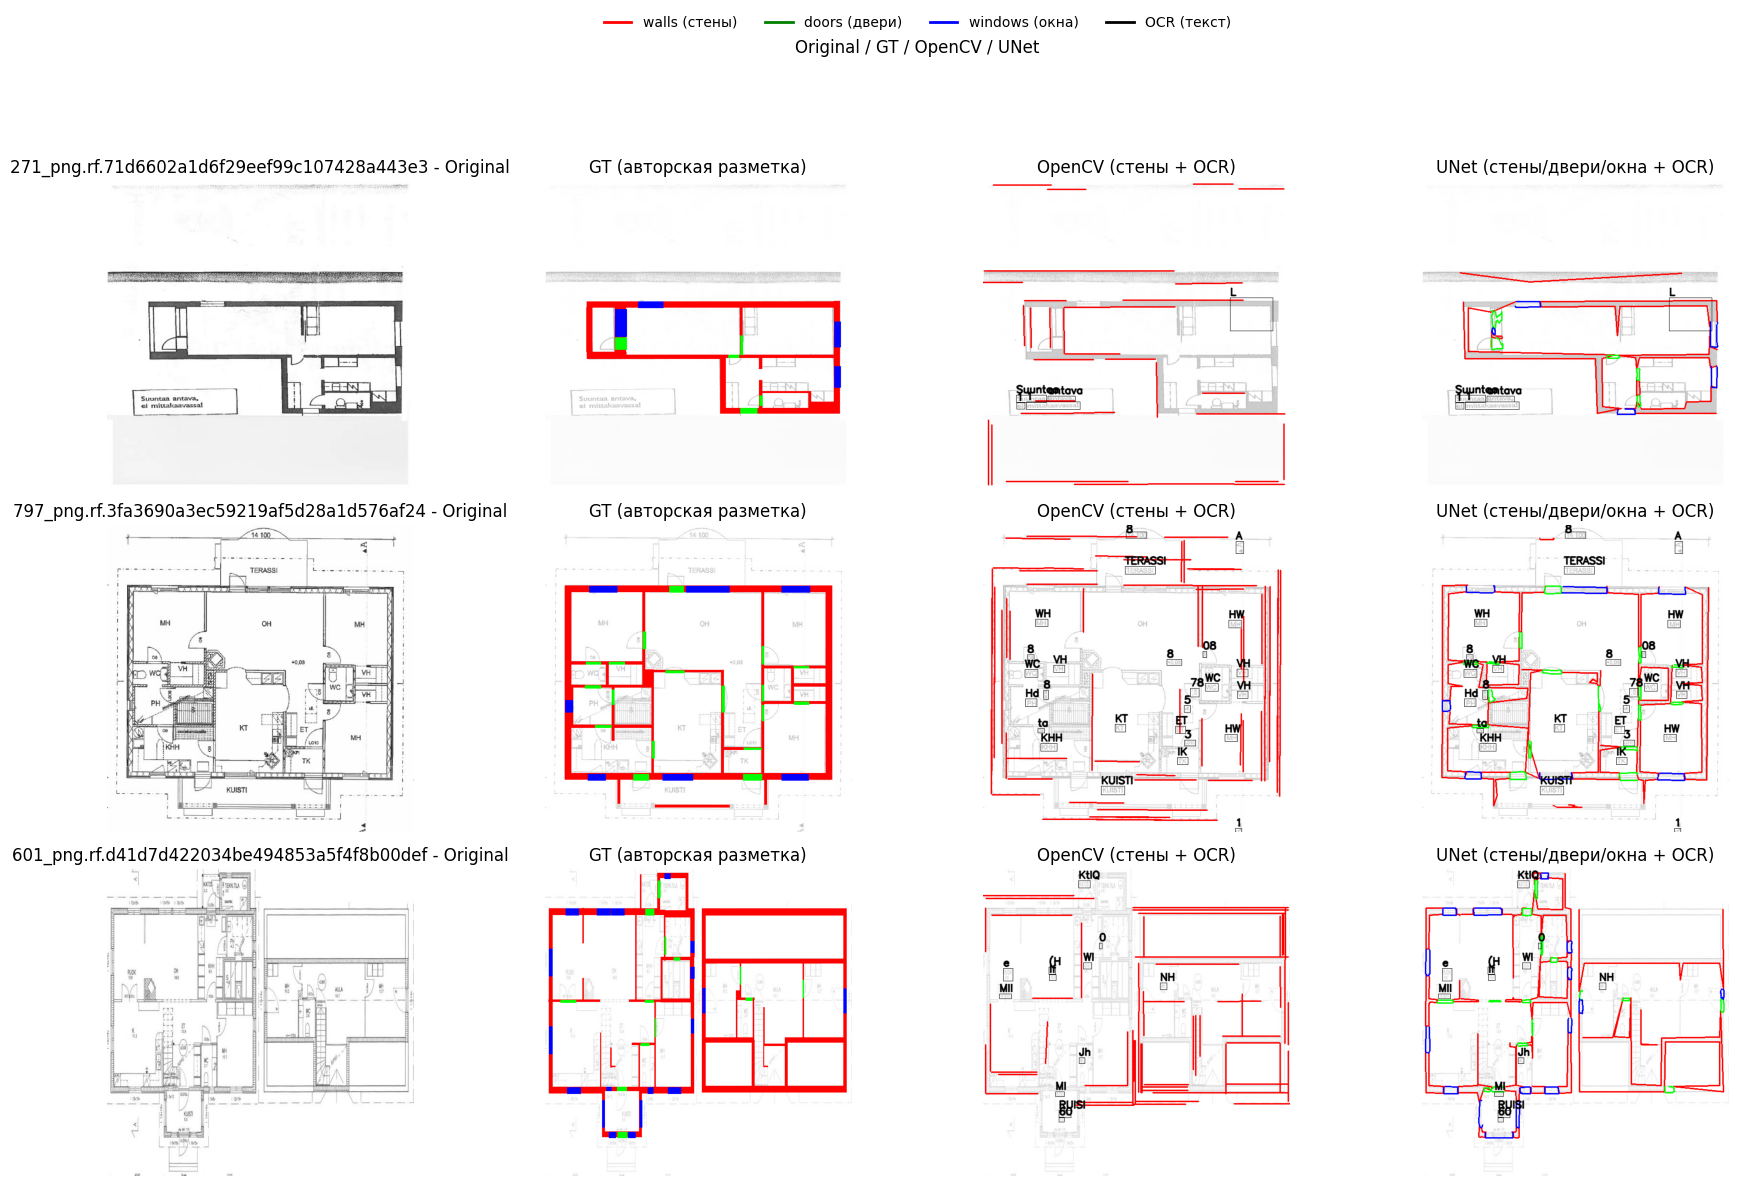

In [30]:
stems = get_common_examples(CV_PRED_DIR, UNET_PRED_DIR, N_EXAMPLES)

fig, axes = plt.subplots(
    nrows=len(stems),
    ncols=4,
    figsize=(18, 4 * len(stems)),
)

if len(stems) == 1:
    axes = np.expand_dims(axes, axis=0)

for row_idx, stem in enumerate(stems):
    # пути
    cv_json_path = CV_PRED_DIR / f"{stem}.json"
    unet_json_path = UNET_PRED_DIR / f"{stem}.json"

    # данные
    img_bgr = load_image_from_json(cv_json_path)  # и cv, и unet используют один source
    gt_mask = load_gt_mask(stem)

    with cv_json_path.open("r", encoding="utf-8") as f:
        cv_data = json.load(f)
    with unet_json_path.open("r", encoding="utf-8") as f:
        unet_data = json.load(f)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # GT
    gt_bgr = draw_gt_on_background(img_bgr, gt_mask, alpha_bg=BG_ALPHA_GT)
    gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB)

    # CV prediction: только стены + OCR
    cv_bgr = draw_predictions_on_background(
        img_bgr,
        cv_data,
        alpha_bg=BG_ALPHA_CV,
        use_walls=True,
        use_doors=False,
        use_windows=False,
        use_ocr=True,
        thickness=2,
    )
    cv_rgb = cv2.cvtColor(cv_bgr, cv2.COLOR_BGR2RGB)

    # UNet prediction: стены/двери/окна + OCR
    unet_bgr = draw_predictions_on_background(
        img_bgr,
        unet_data,
        alpha_bg=BG_ALPHA_UNET,
        use_walls=True,
        use_doors=True,
        use_windows=True,
        use_ocr=True,
        thickness=2,
    )
    unet_rgb = cv2.cvtColor(unet_bgr, cv2.COLOR_BGR2RGB)

    ax0, ax1, ax2, ax3 = axes[row_idx]

    ax0.imshow(img_rgb)
    ax0.set_title(f"{stem} - Original")
    ax0.axis("off")

    ax1.imshow(gt_rgb)
    ax1.set_title("GT (авторская разметка)")
    ax1.axis("off")

    ax2.imshow(cv_rgb)
    ax2.set_title("OpenCV (стены + OCR)")
    ax2.axis("off")

    ax3.imshow(unet_rgb)
    ax3.set_title("UNet (стены/двери/окна + OCR)")
    ax3.axis("off")

fig.suptitle("Original / GT / OpenCV / UNet", y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.90])

add_legend(fig)

plt.show()

